In [42]:
import pandas as pd
import numpy as np
import nltk

import re
import string

import matplotlib.pyplot as plt
import seaborn as sns

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
opinions_df = pd.read_csv('opinions_data.csv')
opinions_df.rename({'Unnamed: 0' : 'Case'}, axis=1, inplace=True)

In [3]:
opinions_df['length'] = opinions_df['Raw Text'].apply(lambda x: len(x))

In [4]:
opinions_df.length.describe()

count      7916.000000
mean      36590.613567
std       37414.455184
min          23.000000
25%        8693.250000
50%       28064.500000
75%       51401.750000
max      564459.000000
Name: length, dtype: float64

In [5]:
def trim_case(raw_text):
    text = raw_text.split('Footnote')[0]
    return text 

In [6]:
opinions_df['Raw Text'] = opinions_df['Raw Text'].apply(lambda x: trim_case(x))

In [7]:
opinions_df['length'] = opinions_df['Raw Text'].apply(lambda x: len(x))
opinions_df.describe()

,length
count,7916.000000
mean,19096.509474
std,31098.788825
min,21.000000
25%,2064.750000
50%,6284.500000
75%,23085.250000
max,564459.000000


In [8]:
# Drop duplicates
print('Before dropping duplicates: ', opinions_df.shape)
opinions_df.drop_duplicates(subset=['Case'],keep='last', inplace=True, ignore_index=True)
print('After dropping duplicates: ', opinions_df.shape)

Before dropping duplicates:  (7916, 3)
After dropping duplicates:  (7741, 3)


# Text Preprocessing

In [9]:
# Sample on 100 cases
# cases = opinions_df.sample(100)

cases = opinions_df

In [10]:
cases.head()

,Case,Raw Text,length
0,ADAMS v. U.S.(1968) No. 875,ADAMS v. U.S.(1968) Solicitor General Griswold...,289
1,AGRICULTURAL BANK v. TAX COMM'N(1968) No. 755,AGRICULTURAL BANK v. TAX COMM'N(1968) Massach...,5510
2,ALBRECHT v. HERALD CO.(1968) No. 43,"ALBRECHT v. HERALD CO.(1968) Petitioner, an i...",13218
3,ALDERMAN v. UNITED STATES(1968) No. 133,ALDERMAN v. UNITED STATES(1968) [,33
4,ALDERMAN v. UNITED STATES.(1968) No. 133,ALDERMAN v. UNITED STATES.(1968) The motion of...,1603


In [11]:
import ftfy

In [12]:
def clean_text(s):
    ftfy.fix_text('âœ” No problems')
    # remove text inside brackets
    s = re.sub(r'(?<=\[)[^][]*(?=])', "", s)
    
    s = s.replace('\n', "").replace('-', ' ').replace('(', ' ').replace('§', '')
    s = s.translate(str.maketrans('', '', string.punctuation))
    s = re.sub(r"\b[0-9]+\b\s*", "", s)
    s = " ".join(s.split())
    s = s.lower()

    return s

In [13]:
cases['clean_text'] = cases['Raw Text'].map(lambda x: clean_text(x))

In [64]:
cases['clean_text'].to_csv('clean_text.csv')

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Document Similarity: vectorization

In [14]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer, ENGLISH_STOP_WORDS

In [49]:
with open('1-1000.txt') as f:
    common_words = f.read()
    
common_words = common_words.replace('\n', ' ').split(' ')

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [54]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords += common_words
# stopwords.append(common_words)
# possibly add more words to the stop words .union(['law', 'case'])

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [55]:
corpus = cases.clean_text
cv = CountVectorizer(ngram_range=(1,3), stop_words=stopwords,
                     min_df=0.05, max_df=0.5,
                     token_pattern=r"\b[a-z]{3,}\b")
cv_doc_word_matrix = cv.fit_transform(corpus)
cv_words = cv.get_feature_names()

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [56]:
tfidf = TfidfVectorizer(stop_words = stopwords, 
                        token_pattern=r"\b[a-z]{3,}\b",
                       min_df=0.05, max_df=0.5,
                       ngram_range=(1,3))
tfidf_doc_word_matrix = tfidf.fit_transform(corpus)
tfidf_words = tfidf.get_feature_names()

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Data Transformation with Gensim

In [96]:
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

import gensim
import gensim.corpora as corpora

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/evelynjohnson/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/evelynjohnson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [82]:
def lemmatize_and_eliminate(text):
    stemmer = WordNetLemmatizer()
    text = [word for word in text.split() if word not in stopwords]
    text = [stemmer.lemmatize(word) for word in text]
    return " ".join(text)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [86]:
# Remove Stop Words
text_processed = cases.clean_text.map(lambda x: lemmatize_and_elminate(x))

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
docs = text_processed.map(lambda doc: doc.split())
# Create Dictionary
id2word = corpora.Dictionary(docs)

# Create corpus
corpus = [id2word.doc2bow(doc) for doc in docs]

print(corpus[:1])

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 2), (18, 1), (19, 1), (20, 1)]]


# LDA w/ Gensim

In [97]:
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=10, 
                                       random_state=100,
                                       chunksize=100,
                                       passes=10,
                                       per_word_topics=True)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
from pprint import pprint
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.025*"officer" + 0.015*"court" + 0.013*"u" + 0.013*"drug" + 0.013*"police" '
  '+ 0.011*"amendment" + 0.011*"fourth" + 0.008*"arrest" + 0.008*"warrant" + '
  '0.007*"reasonable"'),
 (1,
  '0.015*"state" + 0.015*"united" + 0.015*"alien" + 0.012*"congress" + '
  '0.011*"c" + 0.011*"removal" + 0.011*"president" + 0.010*"government" + '
  '0.009*"court" + 0.008*"statute"'),
 (2,
  '0.048*"court" + 0.017*"u" + 0.012*"appeal" + 0.011*"district" + '
  '0.010*"federal" + 0.008*"circuit" + 0.008*"judgment" + 0.007*"action" + '
  '0.007*"f" + 0.007*"review"'),
 (3,
  '0.018*"court" + 0.013*"u" + 0.009*"federal" + 0.009*"congress" + '
  '0.009*"state" + 0.007*"c" + 0.007*"statute" + 0.006*"b" + 0.005*"action" + '
  '0.005*"provision"'),
 (4,
  '0.064*"v" + 0.033*"court" + 0.017*"petitioner" + 0.014*"appeal" + 0.013*"j" '
  '+ 0.013*"respondent" + 0.011*"district" + 0.010*"filed" + 0.010*"attorney" '
  '+ 0.010*"id"'),
 (5,
  '0.023*"trial" + 0.021*"evidence" + 0.015*"court" + 0.012*"defe

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Coherence Score:  0.4291896083012213


# Tuning Number of Topics of LDA Model

In [114]:
def compute_coherence_values(limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.LdaMulticore(corpus=corpus, 
                                           num_topics=num_topics, 
                                           id2word=id2word, random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=docs, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
model_list, coherence_values = compute_coherence_values(start=4, limit=30, step=2)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


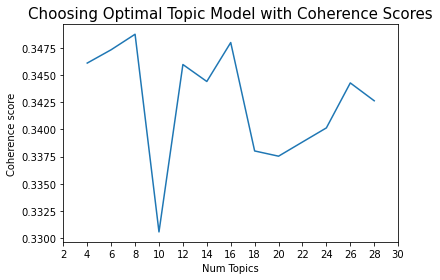

In [113]:
# Show graph
x = range(4, 30, 2)
plt.plot(x, coherence_values)
plt.title("Choosing Optimal Topic Model with Coherence Scores", size=15)
plt.xticks(np.arange(2,32,step=2))
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
# plt.legend(("coherence_values"), loc='best')
plt.savefig("coherence_score.png")

In [116]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
#select the model and print the topics
# model_topics = optimal_model.show_topics(formatted=False)
print(f'''The {x[best_result_index]} topics gives the highest coherence score \
of {coherence_values[best_result_index]}''')

The 8 topics gives the highest coherence score of 0.34873183675927044


/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Final Topic Model 

In [118]:
final_model = gensim.models.LdaMulticore(corpus=corpus,
                               id2word=id2word,
                               num_topics=8,
                               random_state=100,
                               chunksize=100,
                               passes=10)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
import pyLDAvis
import pyLDAvis.gensim_models

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [124]:
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.087456 -0.041983       1        1  25.609706
8     -0.077536 -0.051500       2        1  14.661522
6     -0.102975  0.018768       3        1  14.005481
2     -0.097203  0.021119       4        1  13.761813
7     -0.058647 -0.048479       5        1   9.250572
4      0.063735  0.263529       6        1   8.037976
5     -0.034004  0.007382       7        1   5.717623
0     -0.025934 -0.058120       8        1   4.586641
1     -0.027649 -0.052574       9        1   4.209871
9      0.447669 -0.058142      10        1   0.158793, topic_info=           Term           Freq          Total Category  logprob  loglift
18            v   54747.000000   54747.000000  Default  30.0000  30.0000
572       trial   27098.000000   27098.000000  Default  29.0000  29.0000
8         court  238565.000000  238565.000000  Default  28.0000  28.0000
844     officer   15385.000000   15385.000000  Default  27.0000  27.0000
371    evidence   29214.000000   29214.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
334      dealer      28.174484     874.776378  Topic10  -6.3019   3.0098
46         bank      28.701049    1636.388580  Topic10  -6.2834   2.4020
4387   arkansas      26.955123    1002.485321  Topic10  -6.3461   2.8293
227       union      29.880437    5927.872945  Topic10  -6.2431   1.1551
1914  dependent      26.273146     827.015522  Topic10  -6.3718   2.9960

[912 rows x 6 columns], token_table=        Topic      Freq        Term
term                               
3531        9  0.992081       1105a
116690      9  0.995857       1229a
111500      9  0.998342       1229b
118997     10  0.964351       1437d
228943      1  0.998592       1514a
...       ...       ...         ...
241         6  0.457833        york
241         7  0.019089        york
241         8  0.013022        york
241         9  0.034626        york
284701      9  0.993695  zivotofsky

[3532 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 7, 3, 8, 5, 6, 1, 2, 10])

In [147]:
from pprint import pprint

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [149]:
pprint(final_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"drug" + 0.010*"fda" + 0.009*"warrant" + 0.008*"manufacturer" + '
  '0.008*"police" + 0.007*"vehicle" + 0.007*"officer" + 0.007*"controlled" + '
  '0.007*"safety" + 0.006*"fourth"'),
 (1,
  '0.044*"v" + 0.035*"court" + 0.015*"petitioner" + 0.015*"district" + '
  '0.014*"appeal" + 0.013*"respondent" + 0.011*"united" + 0.010*"state" + '
  '0.010*"j" + 0.009*"filed"'),
 (2,
  '0.023*"court" + 0.017*"u" + 0.010*"officer" + 0.008*"patent" + '
  '0.007*"amendment" + 0.006*"government" + 0.006*"state" + 0.005*"f" + '
  '0.005*"opinion" + 0.005*"fourth"'),
 (3,
  '0.019*"court" + 0.015*"u" + 0.010*"congress" + 0.009*"state" + '
  '0.008*"federal" + 0.007*"c" + 0.006*"statute" + 0.006*"b" + 0.005*"action" '
  '+ 0.005*"united"'),
 (4,
  '0.042*"juror" + 0.015*"montana" + 0.014*"jury" + 0.010*"strike" + '
  '0.009*"trial" + 0.008*"peremptory" + 0.008*"challenge" + 0.008*"court" + '
  '0.007*"discrimination" + 0.007*"prospective"'),
 (5,
  '0.016*"evidence" + 0.015*"court" + 0.009*"

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [136]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=final_model, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9619,"v, court, petitioner, district, appeal, respon...","[adam, v, solicitor, griswold, assistant, atto..."
1,1,1.0,0.5365,"v, court, petitioner, district, appeal, respon...","[agricultural, v, tax, commn, massachusetts, s..."
2,2,1.0,0.4290,"v, court, petitioner, district, appeal, respon...","[albrecht, v, herald, co, petitioner, independ..."
3,3,1.0,0.8248,"v, court, petitioner, district, appeal, respon...","[alderman, v, united, state]"
4,4,2.0,0.5652,"court, u, officer, patent, amendment, governme...","[alderman, v, united, state, united, state, mo..."
5,5,1.0,0.9929,"v, court, petitioner, district, appeal, respon...","[alitalia, linee, aeree, italiane, v, lisi, f2..."
6,6,1.0,0.8904,"v, court, petitioner, district, appeal, respon...","[american, line, v, l, n, r, co]"
7,7,1.0,0.9646,"v, court, petitioner, district, appeal, respon...","[andersen, v, florida, so2d, appeal, dismissed..."
8,8,1.0,0.9843,"v, court, petitioner, district, appeal, respon...","[anderson, v, georgia, certiorari, granted, ga..."
9,9,1.0,0.8840,"v, court, petitioner, district, appeal, respon...","[anderson, v, johnson, f2d, judgment, remains,..."


In [137]:
# Group top 5 sentences under each topic
sent_top_topics_df = pd.DataFrame()

sent_top_topics_grouped_df = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_top_topics_grouped_df:
    sent_top_topics_df = pd.concat([sent_top_topics_df, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_top_topics_df.reset_index(drop=True, inplace=True)

# Format
sent_top_topics_df.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_top_topics_df.head()

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.6054,"drug, fda, warrant, manufacturer, police, vehi...","[birchfieldv, dakota, serious, harm, inflicted..."
1,1.0,0.9964,"v, court, petitioner, district, appeal, respon...","[tennessee, v, arkansas, ordered, adjudged, de..."
2,2.0,0.9995,"court, u, officer, patent, amendment, governme...","[jeremy, carrollvandrew, carmanet, ux, per, cu..."
3,3.0,0.9998,"court, u, congress, state, federal, c, statute...","[hallet, uxv, united, state, chapter, bankrupt..."
4,4.0,0.7229,"juror, montana, jury, strike, trial, peremptor...","[fmc, v, svenska, amerika, linien]"


In [140]:
## Topic Distribution Across Documents

# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics[:20]

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"v, court, petitioner, district, appeal, respon...",62.0,0.0080
1.0,1.0,"v, court, petitioner, district, appeal, respon...",3556.0,0.4594
2.0,1.0,"v, court, petitioner, district, appeal, respon...",415.0,0.0536
3.0,1.0,"v, court, petitioner, district, appeal, respon...",1558.0,0.2013
4.0,2.0,"court, u, officer, patent, amendment, governme...",22.0,0.0028
5.0,1.0,"v, court, petitioner, district, appeal, respon...",297.0,0.0384
6.0,1.0,"v, court, petitioner, district, appeal, respon...",1311.0,0.1694
7.0,1.0,"v, court, petitioner, district, appeal, respon...",520.0,0.0672
8.0,1.0,"v, court, petitioner, district, appeal, respon...",NaN,NaN
9.0,1.0,"v, court, petitioner, district, appeal, respon...",NaN,NaN


# Topic Modeling 

## LDA

In [18]:
# sklearn
from sklearn import datasets
from sklearn.decomposition import LatentDirichletAllocation

In [19]:
lda_cv = LatentDirichletAllocation(n_components=10, random_state=42)
lda_cv.fit(cv_doc_word_matrix)

LatentDirichletAllocation(random_state=42)

In [20]:
lda_tfidf = LatentDirichletAllocation(n_components=10, random_state=42)
lda_tfidf.fit(tfidf_doc_word_matrix)

LatentDirichletAllocation(random_state=42)

## Visualizing Base Topic Model

In [21]:
from __future__ import print_function
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [22]:
#visualize the topics for cv
pyLDAvis.sklearn.prepare(lda_cv, cv_doc_word_matrix, cv)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.048621 -0.089436       1        1  20.259916
1     -0.059803 -0.100448       2        1  13.635261
0     -0.045174  0.014327       3        1  11.184536
7     -0.120848 -0.000094       4        1  10.879579
3     -0.084022  0.141411       5        1   9.917935
9     -0.001028 -0.061195       6        1   9.006088
5     -0.087999 -0.021407       7        1   8.051411
2      0.062719  0.018439       8        1   6.810973
6      0.104735  0.162565       9        1   6.038427
4      0.280040 -0.064161      10        1   4.215874, topic_info=                    Term          Freq         Total Category  logprob  \
1376                jury  18778.000000  18778.000000  Default  30.0000   
2408                 tax  12486.000000  12486.000000  Default  29.0000   
2456               trial  25909.000000  25909.000000  Default  28.0000   
2147              review  18260.000000  18260.000000  Default  27.0000   
237             attorney  12431.000000  12431.000000  Default  26.0000   
...                  ...           ...           ...      ...      ...   
2332             stevens   1857.589473   4417.401655  Topic10  -5.0662   
2112         respondents   2791.303807  19002.322249  Topic10  -4.6590   
832   dissenting opinion   1573.725239   3685.129975  Topic10  -5.2321   
1751         petitioners   2456.993486  22529.991516  Topic10  -4.7866   
2512                 usc   1851.107409   8483.338477  Topic10  -5.0697   

      loglift  
1376  30.0000  
2408  29.0000  
2456  28.0000  
2147  27.0000  
237   26.0000  
...       ...  
2332   2.3000  
2112   1.2483  
832    2.3155  
1751   0.9504  
2512   1.6440  

[562 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
9         1  0.592999  access
9         2  0.186959  access
9         3  0.029350  access
9         4  0.000462  access
9         5  0.065401  access
...     ...       ...     ...
2612      6  0.134726    york
2612      7  0.036759    york
2612      8  0.536577    york
2612      9  0.021623    york
2612     10  0.034430    york

[3809 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 1, 8, 4, 10, 6, 3, 7, 5])

In [23]:
# visualize the topics for tfidf
pyLDAvis.sklearn.prepare(lda_tfidf, tfidf_doc_word_matrix, tfidf)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.075713  0.008870       1        1  52.640891
7      0.041848  0.055246       2        1  17.920471
4     -0.111401 -0.106360       3        1  15.623579
8     -0.214439  0.196020       4        1   4.682404
5     -0.211062 -0.167058       5        1   2.592877
6      0.041290  0.184904       6        1   1.708287
2      0.078887 -0.131688       7        1   1.641559
9      0.152805 -0.030365       8        1   1.331606
3      0.074555  0.008543       9        1   0.941502
0      0.071804 -0.018112      10        1   0.916824, topic_info=                  Term        Freq       Total Category  logprob  loglift
2408               tax  193.000000  193.000000  Default  30.0000  30.0000
2329              stay  129.000000  129.000000  Default  29.0000  29.0000
178       argued cause  222.000000  222.000000  Default  28.0000  28.0000
2189            search  107.000000  107.000000  Default  27.0000  27.0000
238   attorney general  203.000000  203.000000  Default  26.0000  26.0000
...                ...         ...         ...      ...      ...      ...
2102           respect    0.244874   55.390975  Topic10  -7.9488  -0.7294
294              board    0.244869  119.083706  Topic10  -7.9489  -1.4948
409              chief    0.244864   38.409912  Topic10  -7.9489  -0.3634
1371              june    0.244863   29.225453  Topic10  -7.9489  -0.0901
1446              life    0.244862   52.060019  Topic10  -7.9489  -0.6674

[516 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
5         1  0.558821    abuse
5         2  0.298038    abuse
5         3  0.037255    abuse
5         9  0.074510    abuse
16        1  0.107902  accused
...     ...       ...      ...
2612      1  0.418098     york
2612      2  0.090400     york
2612      3  0.146899     york
2612      4  0.316399     york
2612      5  0.022600     york

[1590 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 5, 9, 6, 7, 3, 10, 4, 1])

In [24]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)
    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


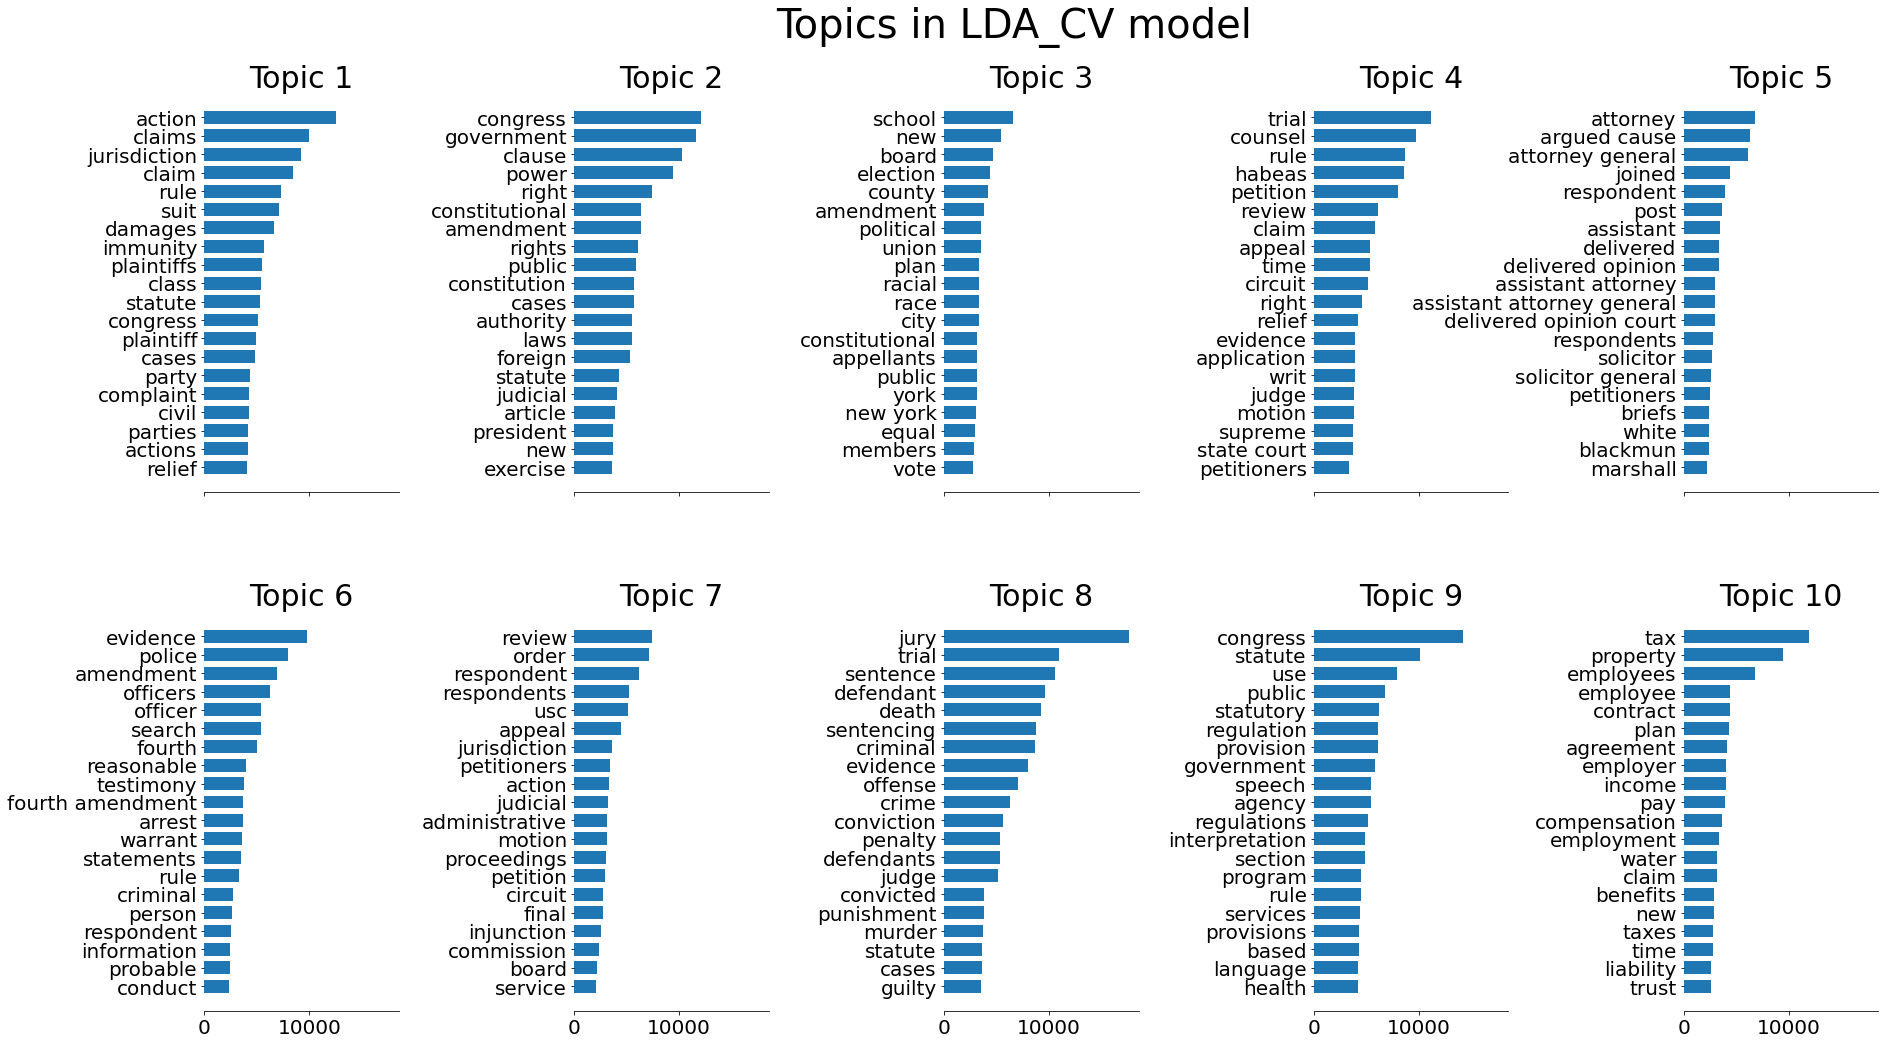

In [26]:
plot_top_words(lda_cv, cv_words, 20, "Topics in LDA_CV model")

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


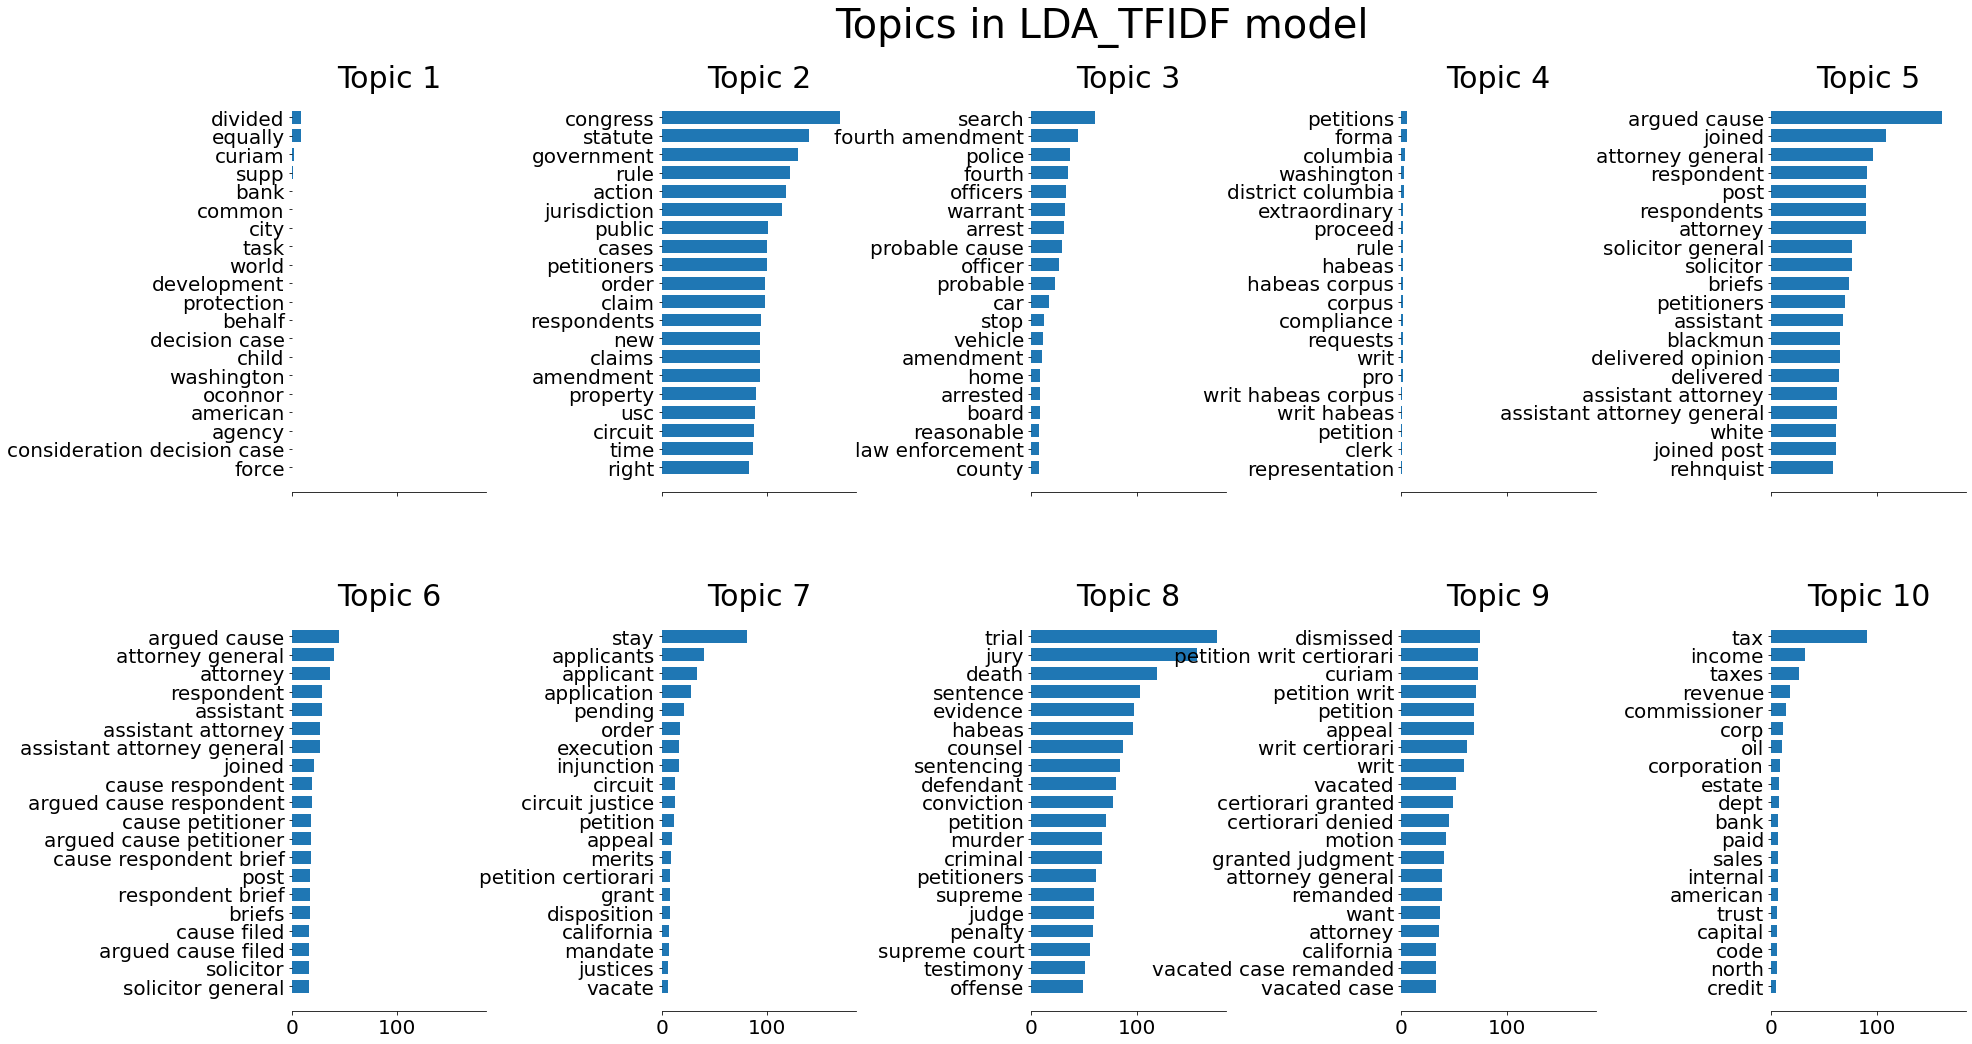

In [27]:
plot_top_words(lda_tfidf, tfidf_words, 20, "Topics in LDA_TFIDF model")

# Topic Modelling: CorEx

In [59]:
from corextopic import corextopic as ct
from corextopic import vis_topic as vt

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [58]:
cv_corex = CountVectorizer(ngram_range=(1,3), stop_words=stopwords,
                     min_df=0.05, max_df=0.5,
                     token_pattern=r"\b[a-z]{3,}\b",
                          binary=True)

cv_corex_doc_word = cv_corex.fit_transform(corpus)
cv_corex_words = list(np.asarray(cv_corex.get_feature_names()))

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [150]:
corex_cv = ct.Corex(n_hidden=10, words=cv_corex_words, seed=1)
corex_cv.fit(cv_corex_doc_word, words=cv_corex_words, docs=corpus)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [151]:
# Print all topics from the CorEx topic model
topics = corex_cv.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: cannot,issue,simply,cases,without,conclusion,app,indeed,although,relevant
1: different,generally,context,finally,legal,analysis,respect,moreover,suggests,significant
2: omitted,quotation,internal quotation,quotation marks,internal quotation marks,marks,marks omitted,quotation marks omitted,jdelivered,jdelivered opinion
3: granted certiorari,within,otherwise,statutory,terms,provision,means,purpose,provides,purposes
4: publication preliminary united,reporter decisions supreme,reporter decisions,readers requested notify,readers requested,requested notify,publication preliminary,requested notify reporter,notify reporter decisions,reports readers requested
5: congress,stat,provisions,enacted,legislative,policy,congressional,inc,rep,amended
6: parties,claims,sought,judicial,litigation,rules,action,seek,actions,alleged
7: delivered opinion,delivered,delivered opinion court,blackmun,joined,rehnquist,briefs,filed dissenting,writ certiorari,filed dissenting opinion
8: constitutional,protectio

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [153]:
corpus_v = cases.clean_text
tfidf = TfidfVectorizer(stop_words = stopwords, 
                        token_pattern=r"\b[a-z]{3,}\b",
                       min_df=0.05, max_df=0.5,
                       ngram_range=(1,3),
                       binary=True)
tfidf_doc_word_matrix = tfidf.fit_transform(corpus_v)
tfidf_words = tfidf.get_feature_names()

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [154]:
corex_tfidf = ct.Corex(n_hidden=10, words=cv_corex_words, seed=1)
corex_tfidf.fit(tfidf_doc_word_matrix, words=tfidf_words, docs=corpus_v)

/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [157]:
# Print all topics from the CorEx topic model
topics = corex_tfidf.get_topics()
for n,topic in enumerate(topics):
    topic_words,_,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: assistant attorney,indeed,assistant,simply,emphasis,granted certiorari,conclude,cert,cannot,argues
1: jdelivered,jdelivered opinion,internal quotation marks,internal quotation,quotation marks,quotation,text,quotation marks omitted,marks omitted,jdelivered opinion court
2: publication preliminary,notify reporter decisions,notify reporter,states reports readers,publication preliminary united,readers requested,requested notify reporter,requested notify,reports readers requested,reports readers
3: blackmun,filed dissenting,filed dissenting opinion,delivered opinion,burger,briefs,delivered opinion court,court burger,opinion court burger,delivered
4: johnson


/Users/evelynjohnson/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: not enough values to unpack (expected 3, got 0)